## Sagnac Frequency - Tilt Correction

## Imports

In [3]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [5]:
config = {}


config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2024-03-08 00:00")
config['tend'] = UTCDateTime("2024-03-20 00:00")

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [6]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [7]:
def __correct_temperature_trend(st, correction, n_shift=0, intercept=False):

    from numpy import roll

    st0 = st.copy()
    if roll == 0:
        temperature = st0.select(channel="*T")[0].data
    else:
        temperature = roll(st0.select(channel="*T")[0].data, n_shift)


    if intercept:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    else:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)

    plt.plot(temperature)

    return st0

## Configurations

### Load Tilt Data

  -> converted data of ROMYT


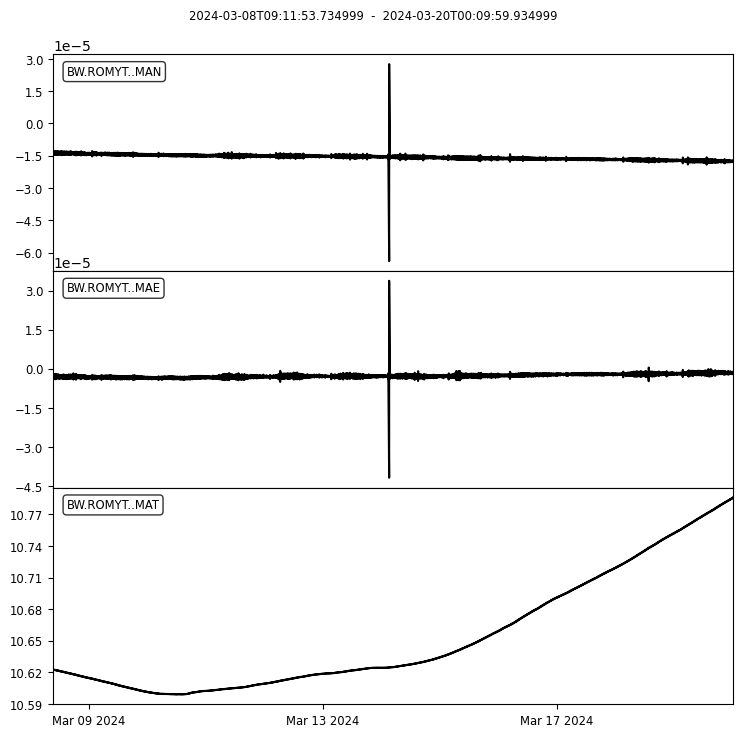

In [8]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")


# tromy0 =  __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

# tromy0 = __conversion_to_tilt(tromy0, confTilt['BROMY'])


tromy0 =  __read_sds(config['path_to_sds'], "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

tromy0 = __conversion_to_tilt(tromy0, confTilt['ROMYT'])


tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

gc.collect();


### Compare Temperature and Tilt

In [1]:
def __compare_tilt_temperature(st0, fmin=None, fmax=1/3600):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth


    tlp = st0.copy()

    tlp = tlp.detrend("linear")

    tlp = tlp.taper(0.1, type="cosine")

    if fmin is None:
        tlp = tlp.filter("lowpass", freq=fmax, corners=4, zerophase=True)
    else:
        tlp = tlp.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

    tlp = tlp.resample(10*fmax, no_filter=True)

    tlp = tlp.merge()


    dt = tlp[0].stats.delta
    times = tlp[0].times()/86400

    arr0 = nan_to_num(tlp.select(channel="*T")[0].data, 0)
    arr1 = nan_to_num(tlp.select(channel="*N")[0].data, 0)
    arr2 = nan_to_num(tlp.select(channel="*E")[0].data, 0)

#     dt = st0[0].stats.delta
#     times = st0[0].times()/86400

#     arr0 = __smooth(nan_to_num(st0.select(channel="*T")[0].data, 0), 3600)
#     arr1 = __smooth(nan_to_num(st0.select(channel="*N")[0].data, 0), 3600)
#     arr2 = __smooth(nan_to_num(st0.select(channel="*E")[0].data, 0), 3600)

    print(len(arr0), len(arr1), len(arr2))

    # arr1 = __interpolate_nan(tromy_lp.select(channel="*T")[0].data)
    # arr2 = __interpolate_nan(tromy_lp.select(channel="*N")[0].data)

    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 4, 2
    font = 12

    fig = plt.figure(figsize=(12, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0)
    ax1.set_ylabel("Temperature (°C)", fontsize=font)

    ax2.plot(times, arr1*1e6, label="N")
    ax2.plot(times, arr2*1e6, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax2.set_xlabel("Time (days)", fontsize=font, labelpad=-8)

    ax3.plot(cclags/3600, ccf1, color="tab:blue")
    # ax3.legend(loc=1)
    ax3.set_ylabel("CC-Coefficient", fontsize=font)
    ax3.set_xlabel("Lag time (hour)", fontsize=font, labelpad=-1)
    ax3.set_ylim(-1, 1)
    ax3.axvline(shift1*dt/3600, -1, 1, color="k", ls="--", zorder=0)
    ax3.scatter(shift1*dt/3600, value1, color="k", marker="d", zorder=0)

    ax4.plot(cclags/3600, ccf2, color="tab:orange")
    # ax4.legend(loc=1)
    ax4.set_ylabel("CC-Coefficient", fontsize=font)
    ax4.set_xlabel("Lag time (hour)", fontsize=font, labelpad=-1)
    ax4.set_ylim(-1, 1)
    ax4.axvline(shift2*dt/3600, -1, 1, color="k", ls="--", zorder=0)
    ax4.scatter(shift2*dt/3600, value2, color="k", marker="d", zorder=0)

    ax5.scatter(arr0, arr1*1e6, color="tab:blue", s=5)
    ax5.plot(xxx, (a1+b1*xxx)*1e6, ls="--", color="k", label=f"a={a1*1e6:.2f}; b={b1*1e6:.2f}")
    ax5.set_xlabel("Temperature (°C)", fontsize=font)
    ax5.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax5.legend()

    ax6.scatter(arr0, arr2*1e6, color="tab:orange", s=5)
    ax6.plot(xxx, (a2+b2*xxx)*1e6, ls="--", color="k", label=f"a={a2*1e6:.2f}; b={b2*1e6:.2f}")
    ax6.set_xlabel("Temperature (°C)", fontsize=font)
    ax6.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax6.legend()

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_temperature(tromy0, fmin=None, fmax=1/(24*3600))


NameError: name 'tromy0' is not defined

### Compute CWT

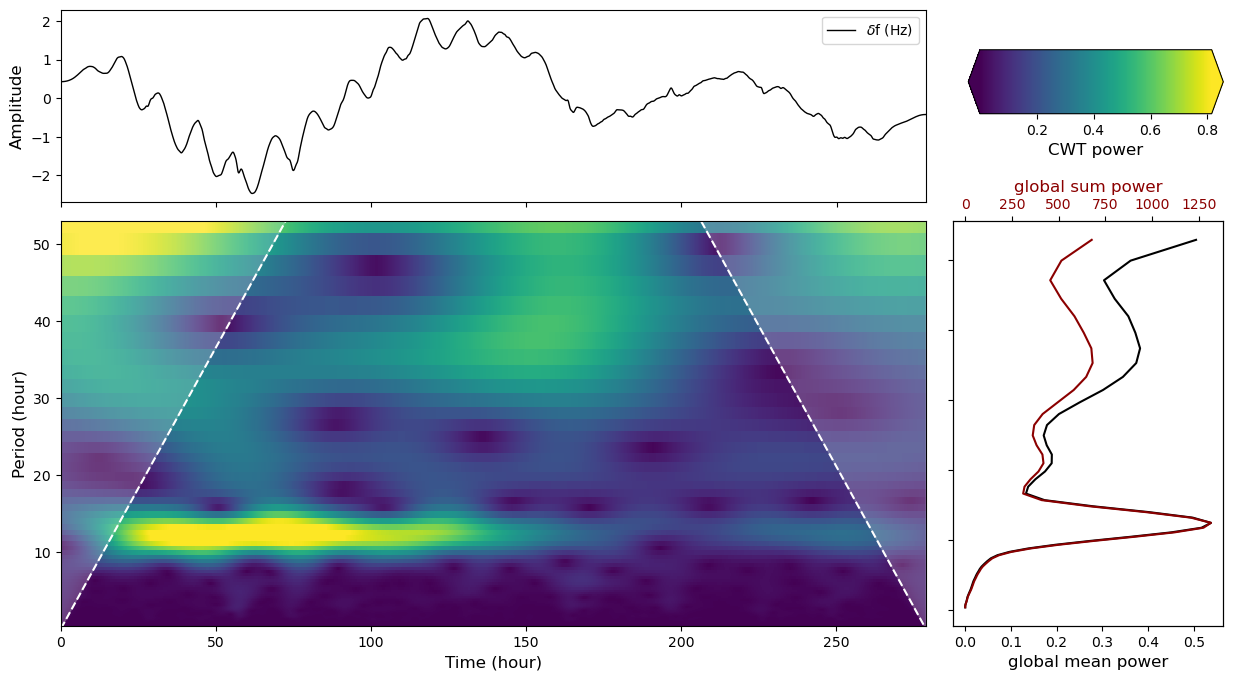

In [19]:
fmin, fmax = None, 1/3600

tlp = tromy0.copy()

tlp = tlp.detrend("linear")

tlp = tlp.taper(0.1, type="cosine")

if fmin is None:
    tlp = tlp.filter("lowpass", freq=fmax, corners=4, zerophase=True)
else:
    tlp = tlp.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

tlp = tlp.resample(10*fmax, no_filter=True)

tlp = tlp.merge()


ttt = tlp[0].times()
arr = tlp.select(channel="*N")[0].data
dt  = tlp[0].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt,
                    tscale="hour",
                    datalabel="$\delta$f (Hz)",
                    scale_value=4,
                    log=False, period=True, ymax=None, plot=True,
                   )

# out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT.png", format="png", dpi=200, bbox_inches='tight')


In [15]:
from pygtide import predict_series

lat = 47.2
lon = 11.2
height = 620
startdate = "2024-01-01"
duration = 24*80 # hours
sampling_rate = 3600

args = (lat, lon, height, startdate, duration, sampling_rate)
series = predict_series(*args, statazimut=90, tidalcompo=8)

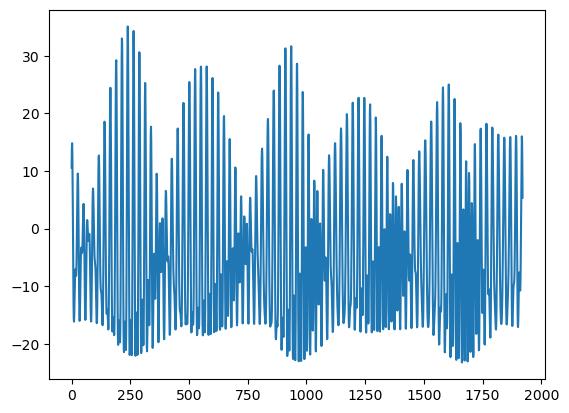

In [16]:
import matplotlib.pyplot as plt
plt.plot(series)

### Apply Correction

In [ ]:
## correction for temperature trends based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")

# from functions.correct_temperature_trend import __correct_temperature_trend

tromy_mod = __correct_temperature_trend(tromy, temperature_correction['TROMY'], n_shift=0, intercept=False)

tromy_mod.plot(equal_scale=False);

## Load Rain Data

In [ ]:
from andbro__load_FURT_stream import __load_furt_stream

In [ ]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [ ]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

In [ ]:
rain = furt.select(channel="LAR")

In [ ]:
rain_cumsum = __cumsum_rain(rain[0].data, 3600)
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)


In [ ]:
# plt.plot(rain_cumsum/np.nanmax(rain_cumsum))
# plt.plot(rain_smooth/np.nanmax(rain_smooth))

In [ ]:
# ws1 = ws1.decimate(6, no_filter=False)
# ws1 = ws1.decimate(10, no_filter=False)

# ws5 = ws5.decimate(6, no_filter=False)
# ws5 = ws5.decimate(10, no_filter=False)

# ws9 = ws9.decimate(6, no_filter=False)
# ws9 = ws9.decimate(10, no_filter=False)

In [ ]:
from functions.smoothing import __smooth

ws1_T = ws1.select(channel="*T")[0].data
ws1_T_smooth = __smooth(ws1_T, 60)
ws1_gradient = np.gradient(ws1_T_smooth, 5)

ws5_T = ws5.select(channel="*T")[0].data
ws5_T_smooth = __smooth(ws5_T, 60)
ws5_gradient = np.gradient(ws5_T_smooth, 5)

ws9_T = ws9.select(channel="*T")[0].data
ws9_T_smooth = __smooth(ws9_T, 60)
ws9_gradient = np.gradient(ws9_T_smooth, 5)

In [ ]:
# # plt.plot(ws1_gradient)
# # plt.plot(ws5_gradient)
# plt.plot(ws1_gradient-ws5_gradient)

# plt.ylim(-0.01, 0.01)

## Plotting

## Tilt

In [ ]:
def __makeplot():

    dat = np.array(bs.w_s)

    tr = Trace()
    tr.data = dat
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    hr1 = 1
    tr1 = tr.copy()
    tr1 = tr1.detrend("demean")
    tr1 = tr1.taper(0.01)
    tr1 = tr1.filter("lowpass", freq=1/(hr1*3600), corners=2, zerophase=True)

    hr2 = 24
    tr2 = tr.copy()
    tr2.data = __sagnac_to_tilt(__interpolate_nan(dat), "U")
    tr2 = tr2.detrend("simple")
    tr2 = tr2.taper(0.01)
    tr2 = tr2.filter("lowpass", freq=1/(hr2*3600), corners=2, zerophase=True)

    scaling_factor = 0.01

    Nrow, Ncol = 2, 1

    font = 12

    tilt_scaling = 1e6
    time_scaling = 1

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="grey", alpha=0.5, label=f"$\Delta$f w/ backscatter")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="black", label=f"$\Delta$f w/ backscatter (smoothed)")
    # ax[0].plot(bs.time_sec*time_scaling, tr1.data*1e3, color="black", label=f"$\Delta$f w/o backscatter (lp < {hr1} hour)")
    ax[0].set_ylim(302.41, 302.52)
    ax[0].ticklabel_format(useOffset=False)


    # ax[1].plot(bs.time_sec*time_scaling,
    #            tr2.data*tilt_scaling*scaling_factor,
    #            ls="--", color="k", label=f"{scaling_factor}* N-S tilt by $\Delta$f (lp < {hr2} hour)",
    #            zorder=2,
    #           )

    tromy_tilt = tromy.select(channel="*N")[0].data
    ax[1].plot(tromy.select(channel="*N")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:orange", label=f"N-S tilt",
               zorder=2,
              )

    tromy_tilt = tromy.select(channel="*E")[0].data
    ax[1].plot(tromy.select(channel="*E")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:purple", label=f"E-W tilt",
               zorder=2,
              )

    ax11 = ax[1].twinx()
    ax11.fill_between(rain[0].times(reftime=ref_time)*time_scaling, rain_smooth, alpha=0.6, zorder=1)
    ax11.set_ylim(bottom=0)
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.tick_params(axis="y", colors="tab:blue")
    ax11.set_ylabel("Cumulative Rain (mm/hour)", fontsize=font, color="tab:blue")

    ax12 = ax[1].twinx()
    p12 = ax12.plot(tromy.select(channel="*T")[0].times(reftime=ref_time)*time_scaling,
                    tromy.select(channel="*T")[0].data, alpha=0.6, zorder=1, color="darkred", ls="--")

    # ax12.set_ylim(bottom=0)
    # ax12.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    # ax12.tick_params(axis="y", colors="tab:blue")
    ax12.set_ylabel("Temperature (°C)", fontsize=font, color="darkred")
    ax12.tick_params(axis='y', colors="darkred")
    ax12.spines.right.set_position(("axes", 1.10))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=1, fontsize=font-1)
    ax[1].legend(loc=1, fontsize=font-1, ncol=1)

    ax[0].set_ylabel(f"$\Delta$f (mHz)", fontsize=font)

    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    gc.collect();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Rain_example.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __makeplot():


    f11 = 1/(14*3600)
    f12 = 1/(10*3600)

    f21 = 1/(26*3600)
    f22 = 1/(22*3600)

    detrend="demean"
    taper = 0.1
    corners = 4

    tr = Trace()
    tr.data = __sagnac_to_tilt(np.array(bs.fj_fs_inter), "U")
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    tr1 = tr.copy()
    tr1 = tr1.detrend(detrend).detrend("simple")
    tr1 = tr1.taper(taper)
    tr1 = tr1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)

    tr2 = tr.copy()
    tr2 = tr2.detrend(detrend).detrend("simple")
    tr2 = tr2.taper(taper)
    tr2 = tr2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)


    tromy1 = tromy.select(channel="*N").copy();
    tromy1 = tromy1.split()
    tromy1 = tromy1.detrend(detrend).detrend("simple")
    tromy1 = tromy1.taper(taper)
    tromy1 = tromy1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)
    tromy1 = tromy1.merge()


    tromy2 = tromy.select(channel="*N").copy();
    tromy2 = tromy2.split()
    tromy2 = tromy2.detrend(detrend).detrend("simple")
    tromy2 = tromy2.taper(taper)
    tromy2 = tromy2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)
    tromy2 = tromy2.merge()


    Nrow, Ncol = 2, 1

    font = 12

    scaling = 1e9

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(tromy1[0].times(reftime=ref_time), -tromy1[0].data*scaling, color="black", label="-1* N-S Tilt")
    ax[1].plot(tromy2[0].times(reftime=ref_time), -tromy2[0].data*scaling, color="black", label="-1* N-S Tilt")

    ax0 = ax[0].twinx()
    ax0.plot(tr1.times(reftime=ref_time), tr1.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax1 = ax[1].twinx()
    ax1.plot(tr2.times(reftime=ref_time), tr2.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    # ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax0.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")
    ax1.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax0.legend(loc=4)
    ax1.legend(loc=4)

    ax[0].text(.01, .97, '(a) 11-13 h', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .97, '(b) 23-25 h', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    ax[0].set_ylim(-40, 40)
    ax[1].set_ylim(-15, 15)

    ax0.tick_params(axis='y', colors='darkred')
    ax0.set_yticks(np.linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax[0].get_yticks())))

    ax1.tick_params(axis='y', colors='darkred')
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax[1].get_yticks())))

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Tides.png", format="png", dpi=150, bbox_inches='tight')
